In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import random
import seaborn as sns
import itertools as it

from metric_voting import *
from metric_voting.plotting import *

%load_ext autoreload
%autoreload 2

In [39]:
# Colors for plotting!
#pal = sns.color_palette("hls", 8)
#tab20_colors = plt.cm.tab20b.colors
colors = ["#0099cd","#ffca5d","#00cd99","#99cd00","#cd0099","#9900cd","#8dd3c7",
        "#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5","#bc80bd",
        "#ccebc5","#ffed6f","#ffffb3","#a6cee3","#1f78b4","#b2df8a","#33a02c",
        "#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a","#b15928",
        "#64ffda","#00B8D4","#A1887F","#76FF03","#DCE775","#B388FF","#FF80AB",
        "#D81B60","#26A69A","#FFEA00","#6200EA",
    ]

#colors2 = colors[:6] + colors[-12::2]
colors2 = colors[:6] + [colors[8]] + [colors[9]] +colors[-7:]
#colors2 = colors[:14]

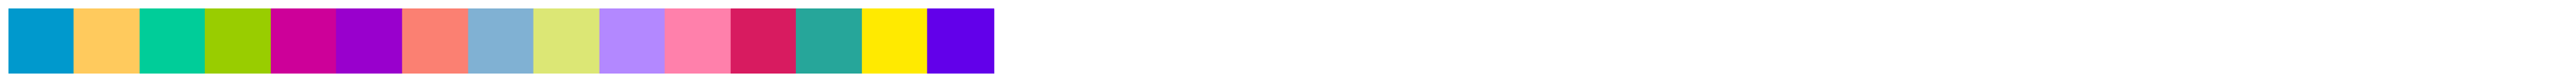

In [40]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(len(colors), 1))

# Create a horizontal color bar
for i, color in enumerate(colors2):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

# Set limits and remove axes
ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)
ax.axis("off")

plt.show()

In [5]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 18
})

### Example inefficiency

In [6]:
f = '../data/two_bloc/example_ineff.npz'
loaded_data = np.load(f, allow_pickle = True)
worst_bloc_dict = {key: loaded_data[key] for key in loaded_data.files}

for ky,vl in worst_bloc_dict.items():
    if ky not in ['voters', 'candidates']:
        worst_bloc_dict[ky] = vl.item()

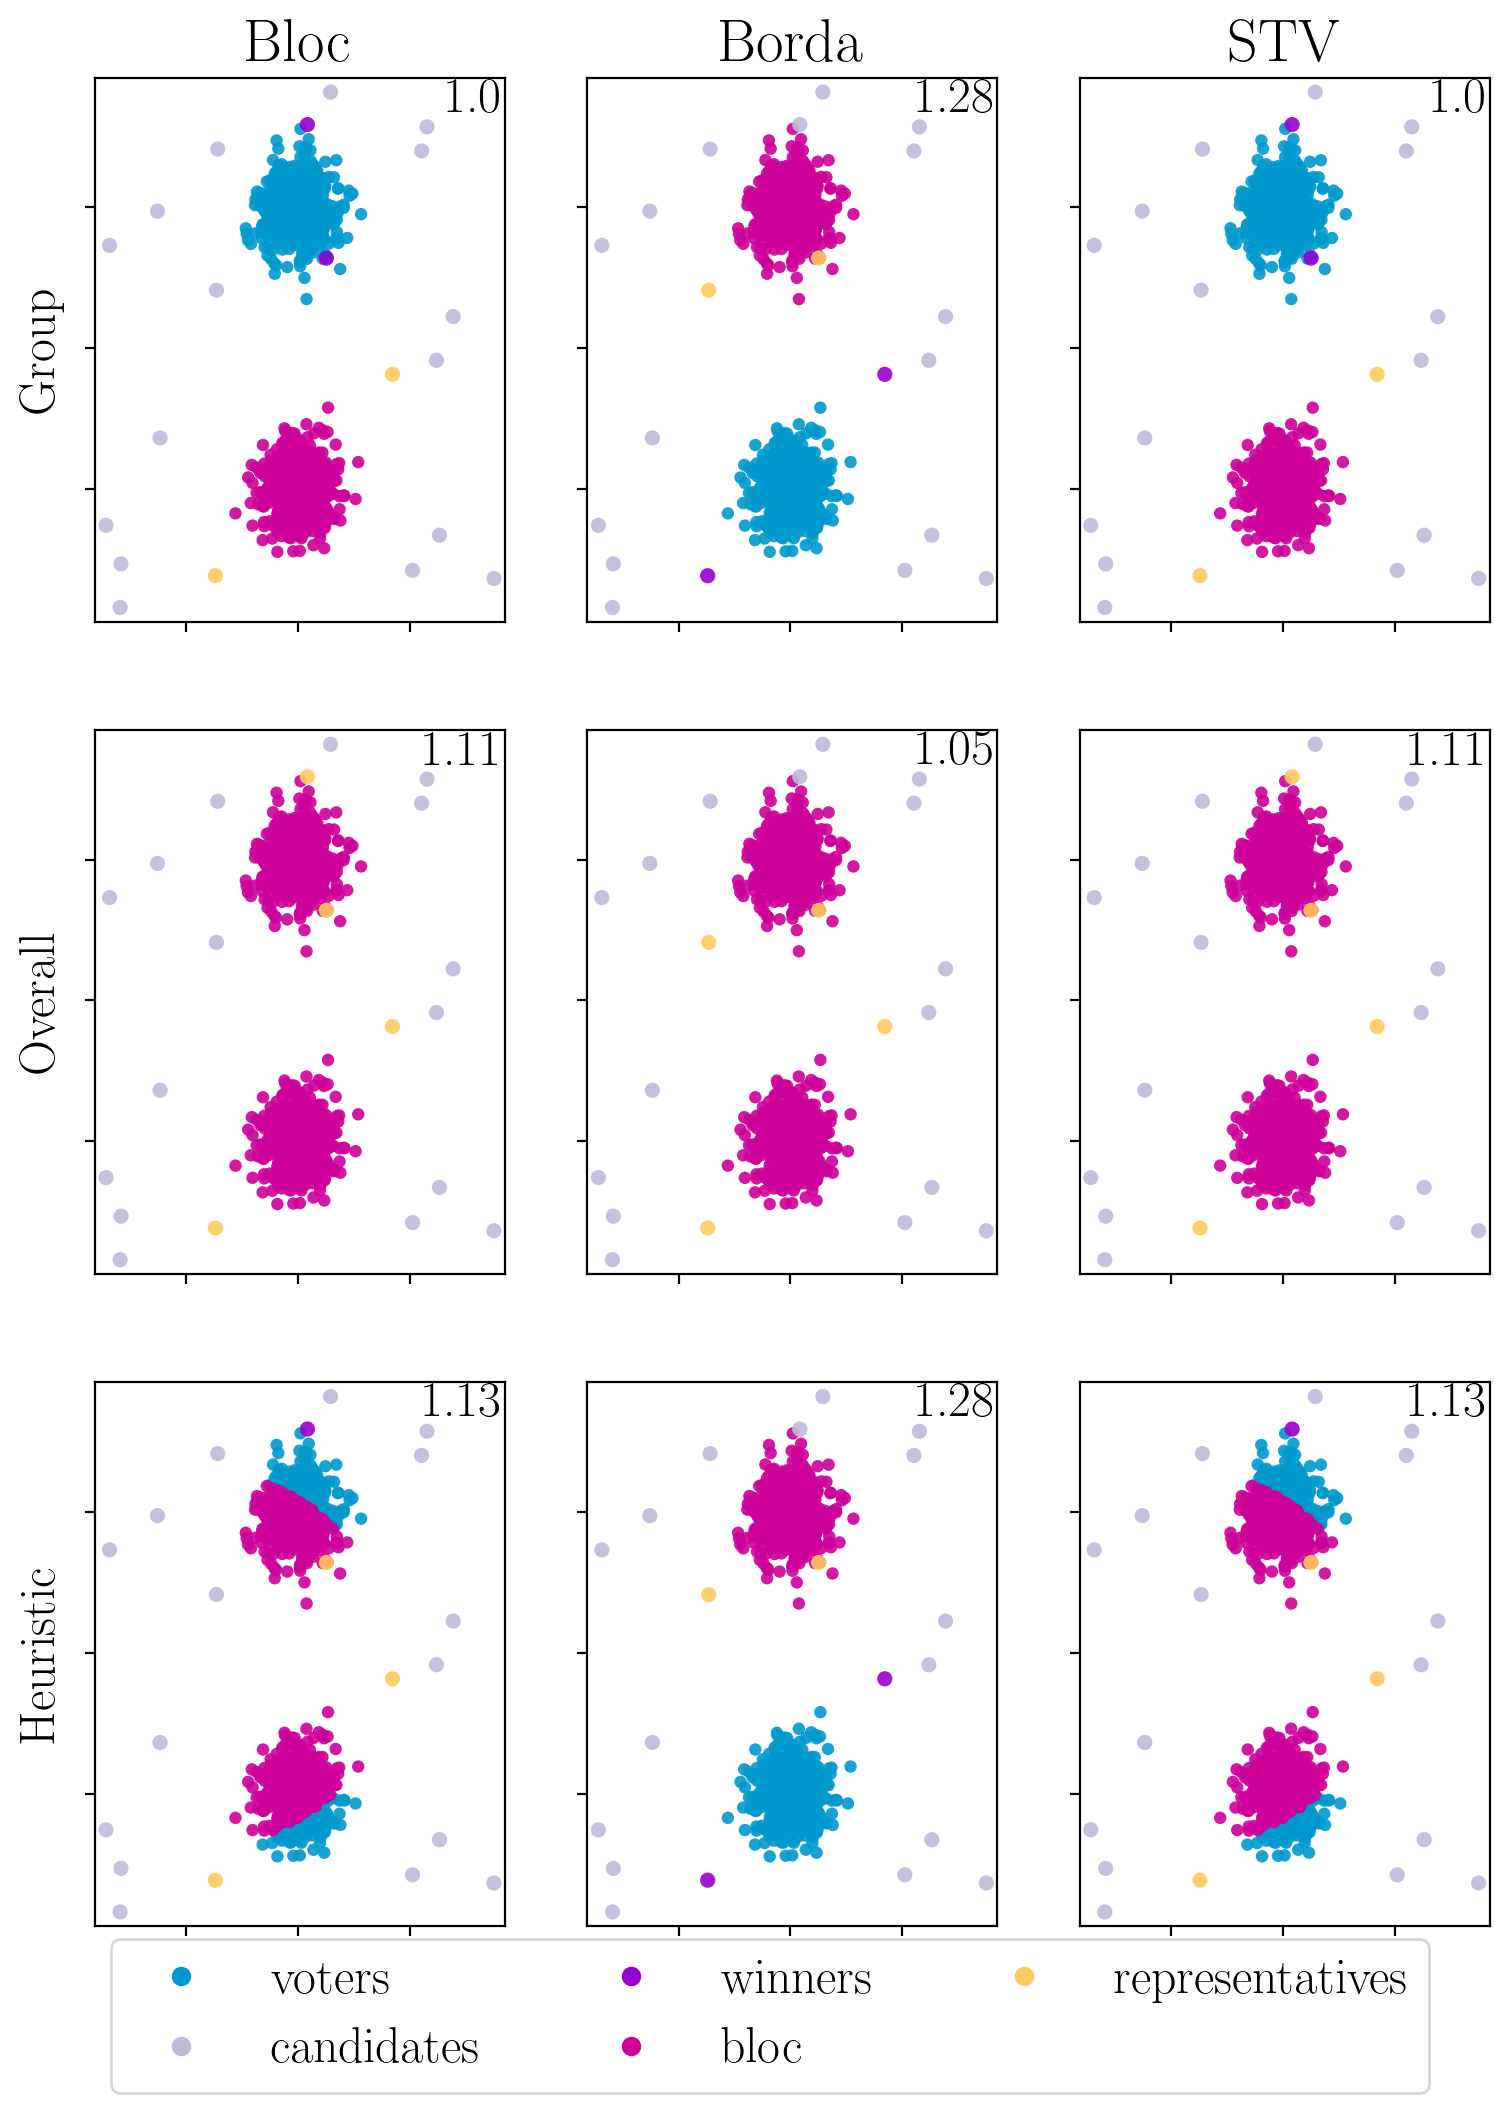

In [33]:
plot_ineff_example(
    results = worst_bloc_dict,
    fig_params = {'figsize' : (9, 12), 'dpi' : 200},
    colors = [colors[0], colors[7], colors[5], colors[4], colors[1]],
    output_file = None
)

### Group, Overall, Worst bloc Inefficiency

In [34]:
f = '../data/two_bloc/samples.npz'
loaded_data = np.load(f)
result_dict = {key: loaded_data[key] for key in loaded_data.files}
n_samples = result_dict['voters'].shape[0]

In [50]:
f = '../data/two_bloc/worst_bloc.npz'
loaded_data = np.load(f)
worst_bloc_dict = {key: loaded_data[key] for key in loaded_data.files}
worst_bloc_dict['PAV'] = worst_bloc_dict['Monroe']

In [51]:
##############################################################################################################
# Compute results:
elections = [_ for _ in result_dict.keys() if _ not in ['voters', 'candidates', 'voter_labels', 'candidate_labels']]

# 1) Using known group labels
group_ineff = {e : np.zeros(n_samples) for e in elections}
# 2) Or instead treat everyone as one group
overall_ineff = {e : np.zeros(n_samples) for e in elections}
# 3) Or for the estimated worst case voter block
worst_ineff = {e : np.zeros(n_samples) for e in elections}

group_select = 1
for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    cst_array = euclidean_cost_array(voter_positions, candidate_positions)
    
    group_labels = result_dict['voter_labels'][i]
    overall_labels = np.zeros(len(group_labels))
    
    for j, e in enumerate(elections):
        winner_indices = np.where(result_dict[e][i])[0]
        
        #worst_bloc = heuristic_worst_bloc2(cst_array, winner_indices, max_size = 1)
        #worst_labels = np.zeros(len(group_labels))
        #worst_labels[worst_bloc] = 1
        worst_labels = worst_bloc_dict[e][i]
        
        grp_ineff = group_inefficiency(cst_array, winner_indices, group_labels, group_select)
        ovr_ineff = group_inefficiency(cst_array, winner_indices, overall_labels, 0)
        wrst_ineff = group_inefficiency(cst_array, winner_indices, worst_labels, 1)
        
        group_ineff[e][i] = grp_ineff
        overall_ineff[e][i] = ovr_ineff
        worst_ineff[e][i] = wrst_ineff
        
group_data = np.array([values[~np.isnan(values)] for values in group_ineff.values()])
overall_data = np.array([values[~np.isnan(values)] for values in overall_ineff.values()])
worst_data = np.array([values[~np.isnan(values)] for values in worst_ineff.values()])
labels = ['CC' if e == 'ChamberlinCourant' else e for e in elections]
labels = ['Expanding' if e == 'ExpandingApprovals' else e for e in labels]
##########################################################################################################

Text(0, 0.5, 'Group-Inefficiency')

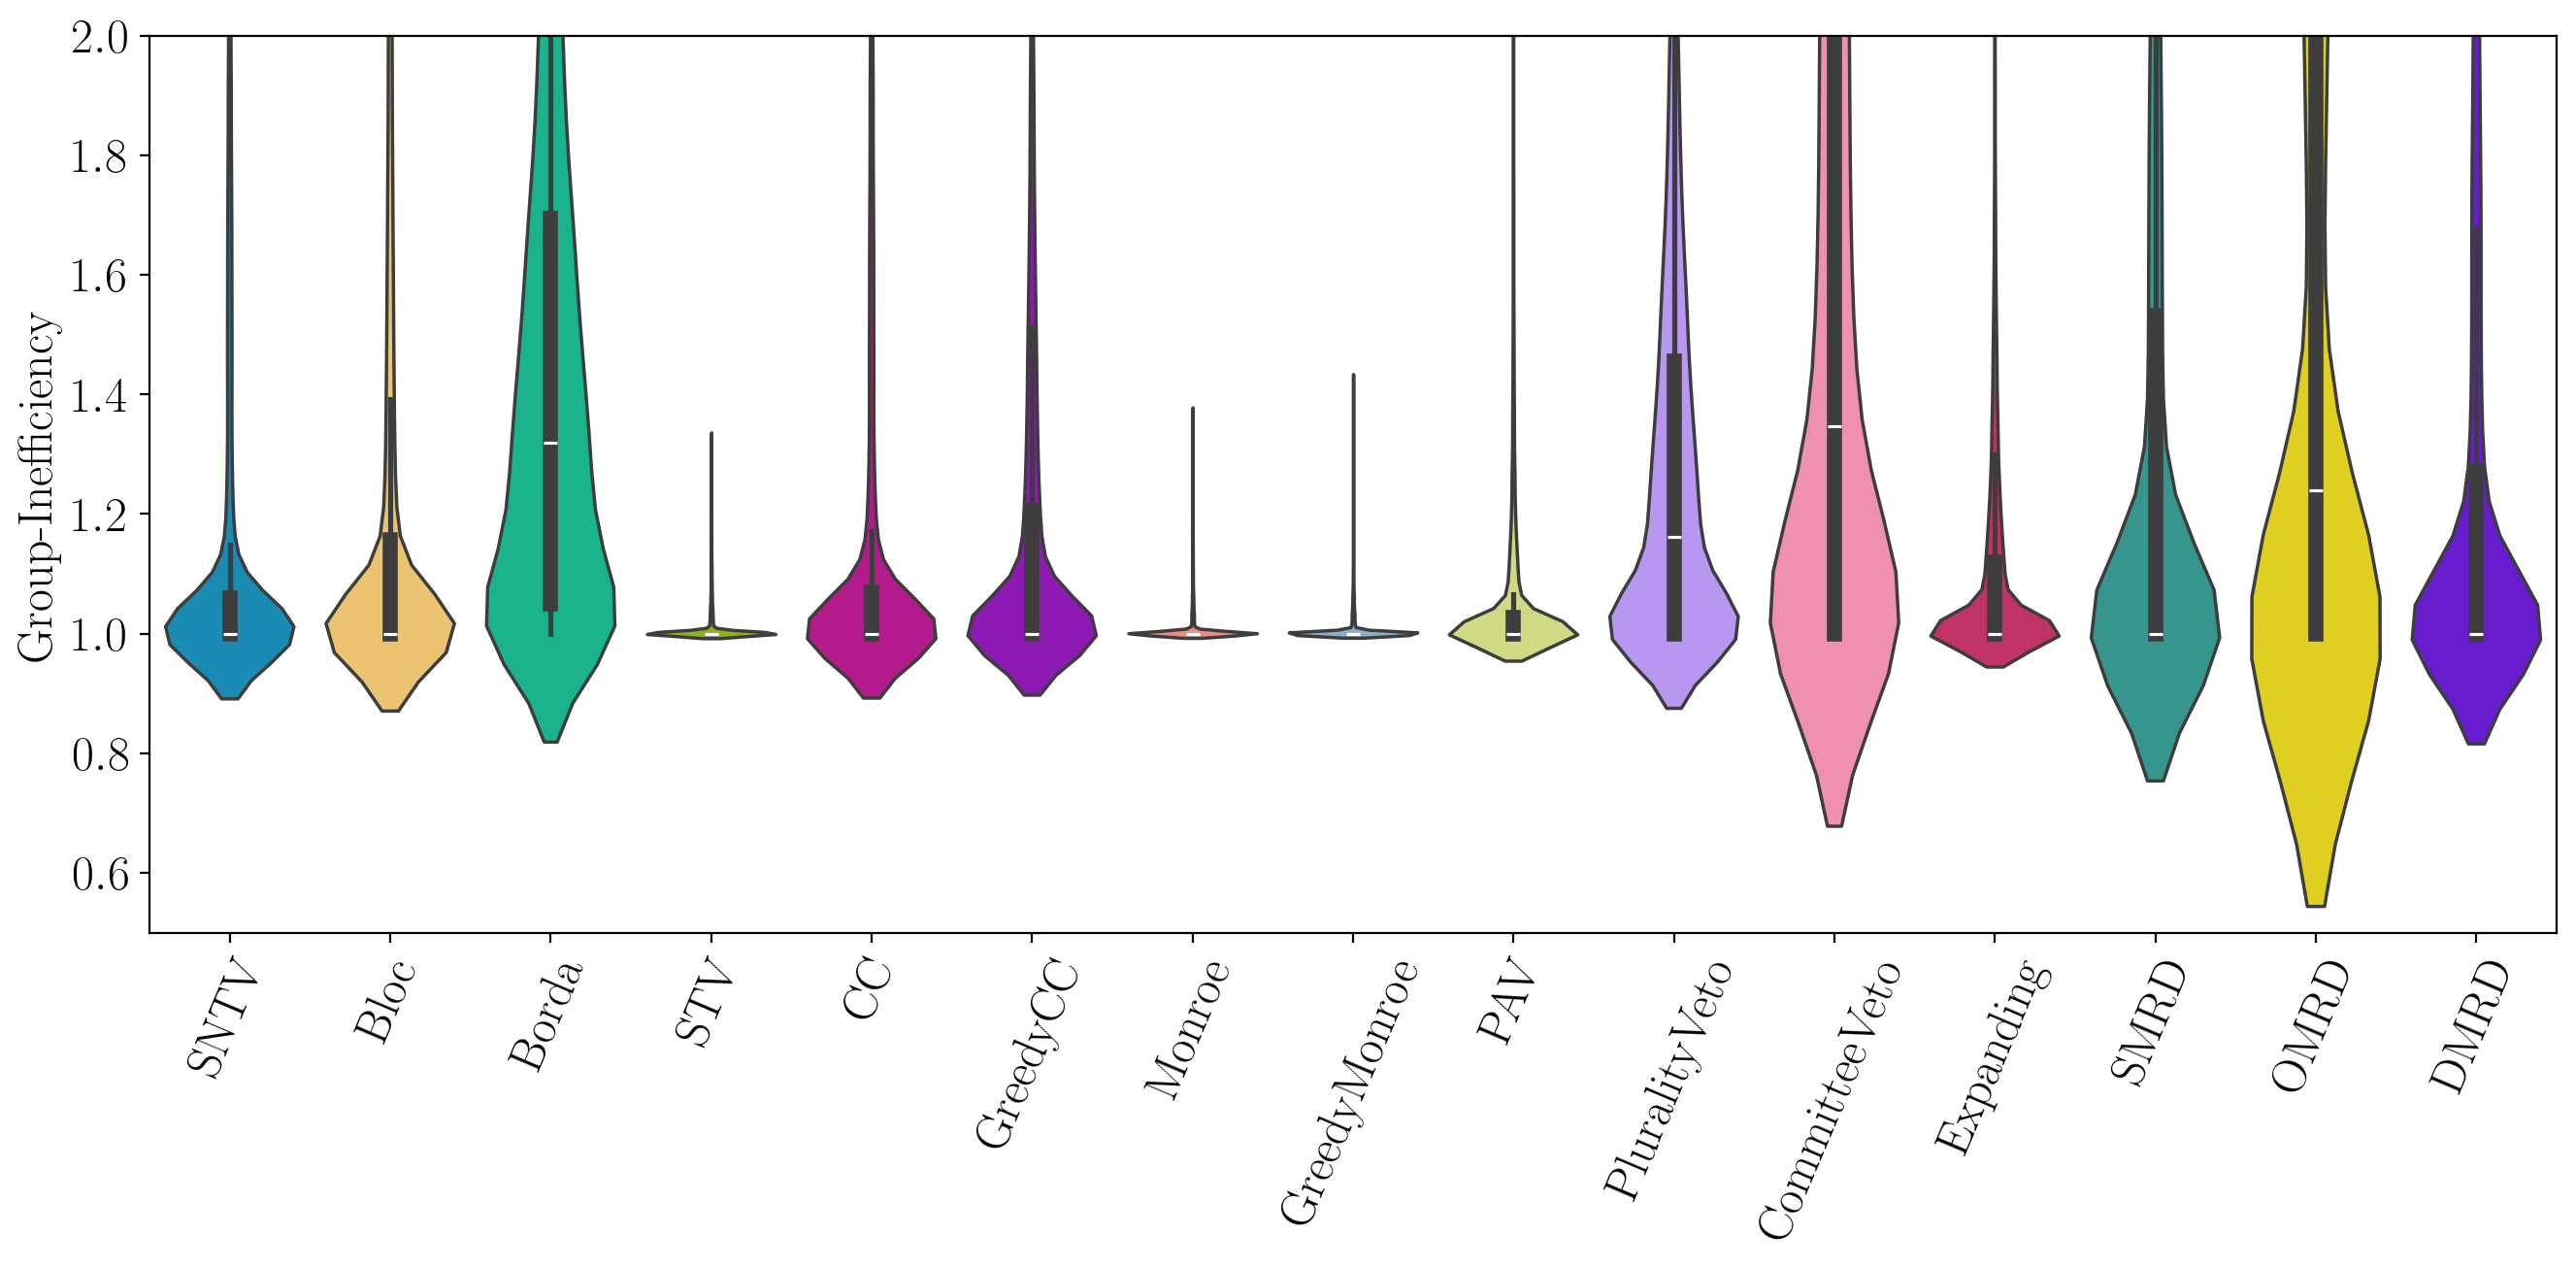

In [41]:
#########################################################################################################################
# Plot Group Inefficiency Analysis:
plt.figure(figsize=(16, 6), dpi = 200)

ax = sns.violinplot(data=group_data.T, palette = colors2, alpha = 1, width = 0.8)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0.5, 2)
#ax.set_ylim(0.95,1.05)
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=67)
plt.ylabel('group-inefficiency'.title())
#plt.savefig('../figures/2blocs_1000voters/group_ineff.png', dpi = 200, bbox_inches = 'tight')
#####################################################################################################################

Text(0, 0.5, 'Overall-Inefficiency')

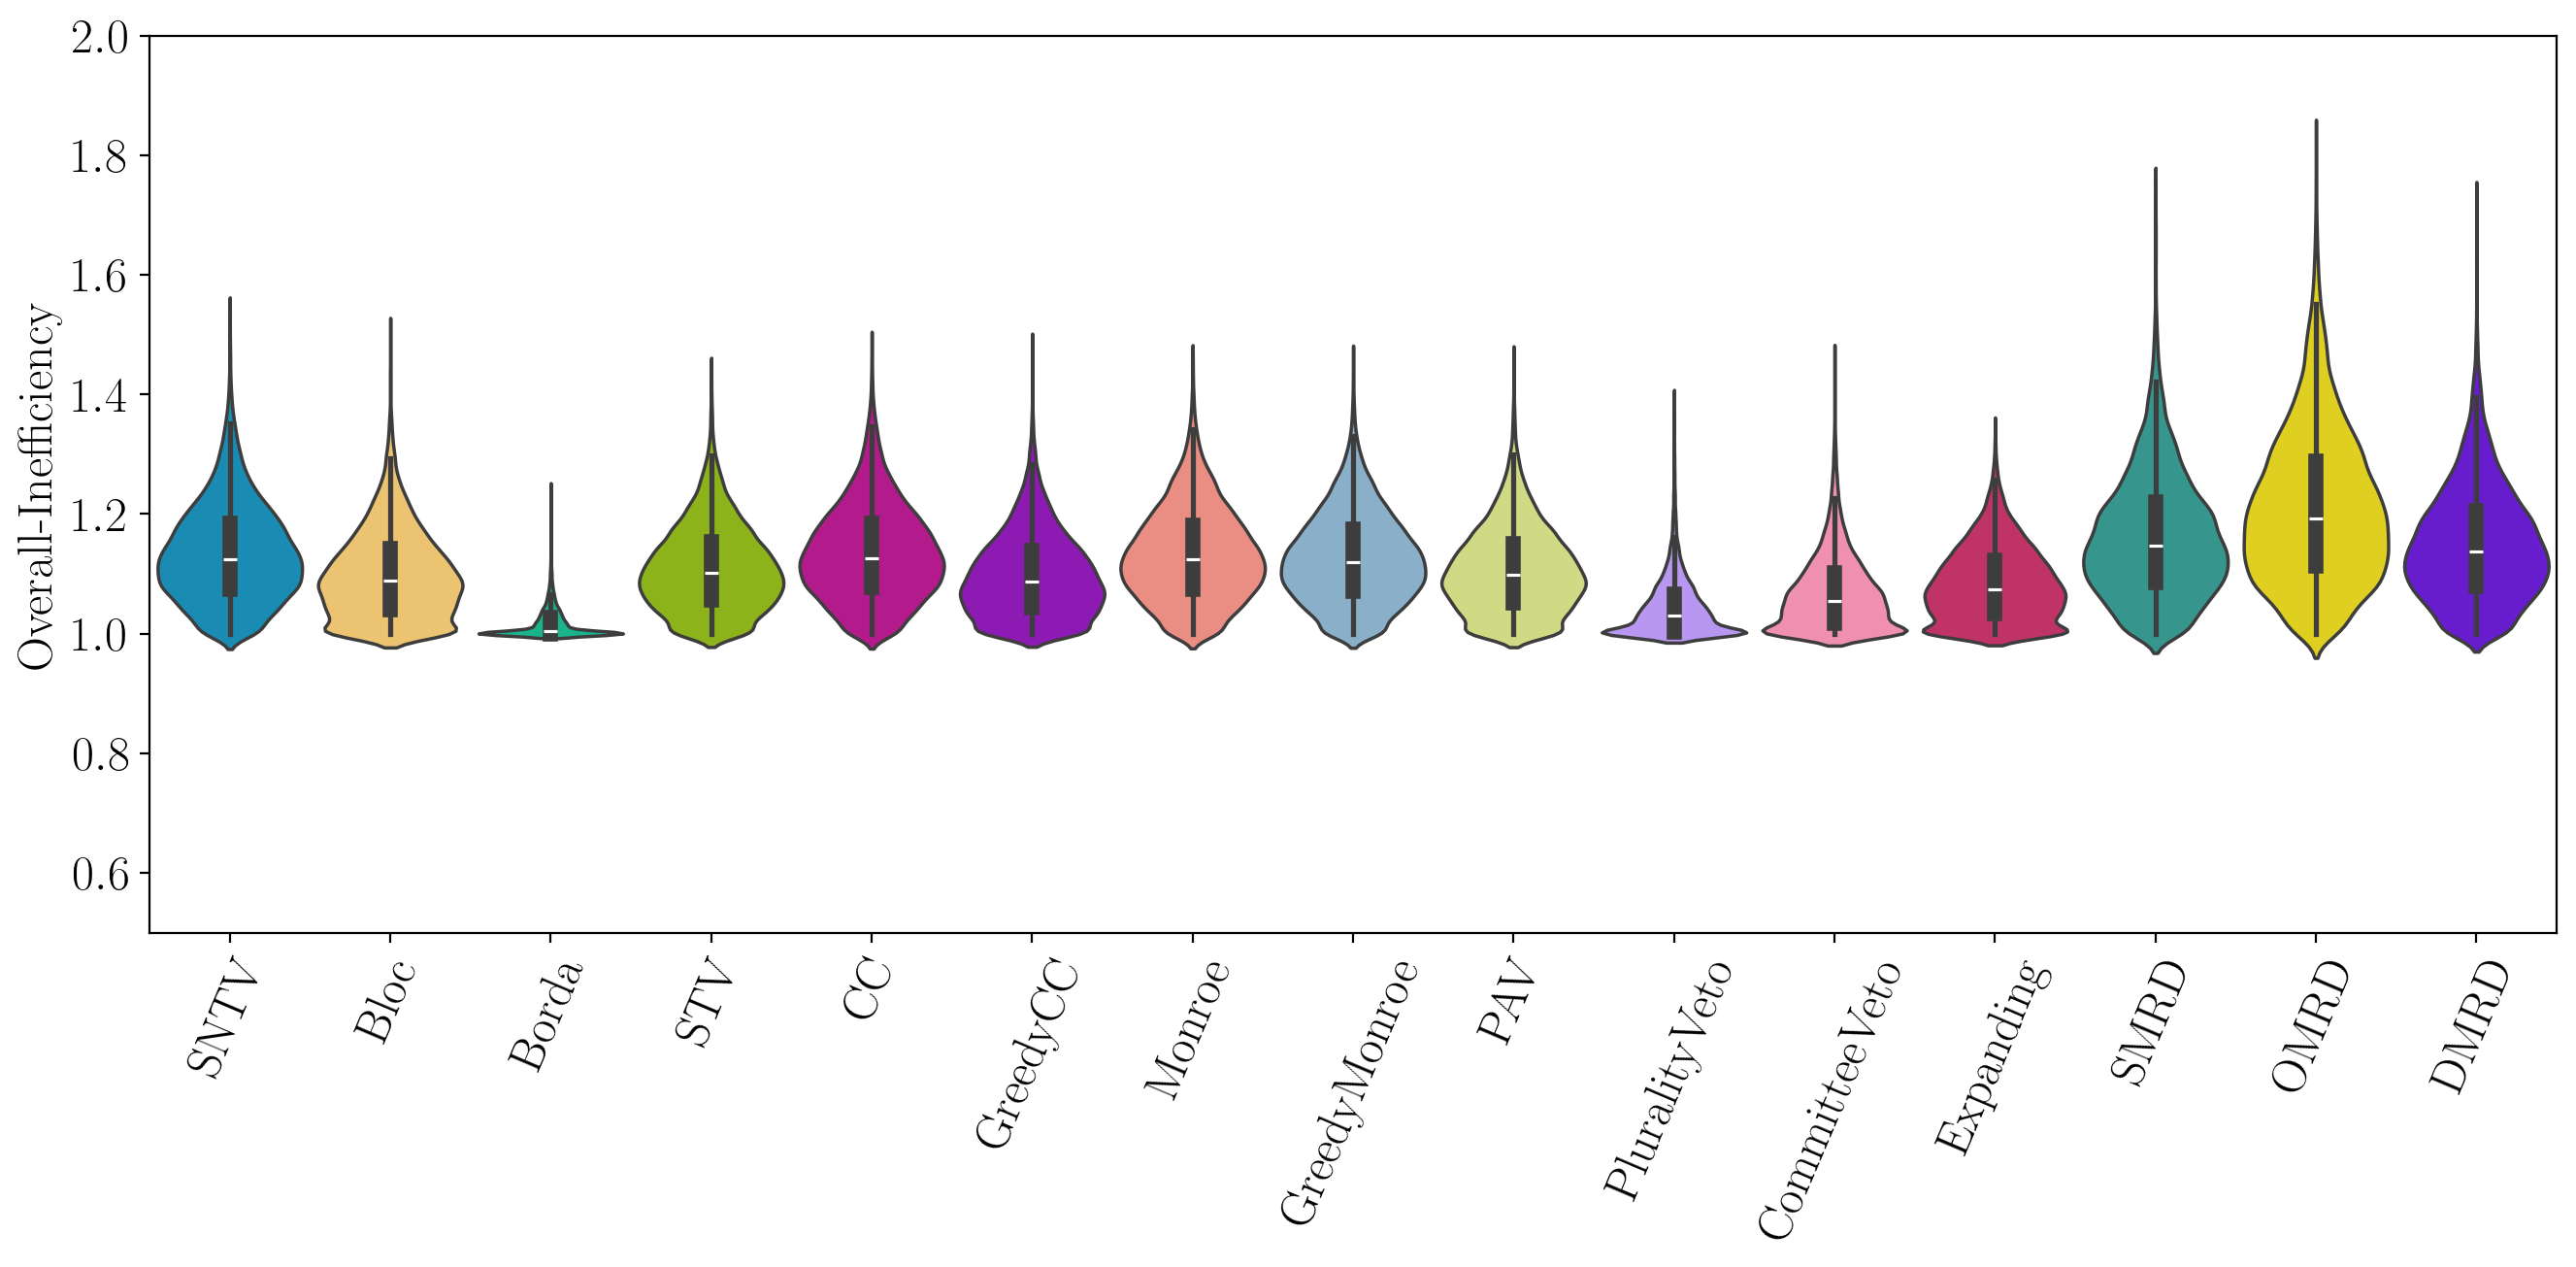

In [42]:
##################################################################################################
# Plot Overall Inefficiency Analysis:
plt.figure(figsize=(16, 6), dpi = 200)

ax = sns.violinplot(data=overall_data.T, palette = colors2, alpha = 1, width = 0.9)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0.5, 2)
#ax.set_ylim(0.95, 1.05)
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=67)
plt.ylabel('overall-inefficiency'.title())
#plt.savefig('../figures/2blocs_1000voters/overall_ineff.png', dpi = 200, bbox_inches = 'tight')
#################################################################################################33

In [ ]:
#################################################################################################
# Plot worst Inefficiency Analysis:
plt.figure(figsize=(16, 6), dpi = 200)

ax = sns.violinplot(data=worst_data.T, palette = colors2, alpha = 1, width = 0.9)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0.5, 2)
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=67)
plt.ylabel('(estimate) worst-group-inefficiency')

################################################################################################

Text(0, 0.5, '(estimate) worst-group-inefficiency')